In [1]:
import os
os.chdir('/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart_sim/walmart_EDA/EDA_Scripts')

import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 


from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score, adjusted_rand_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import DBSCAN, HDBSCAN

from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

import umap
import umap.plot
from collections import defaultdict

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

from product_categorizer import ProductCategorizer

/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart_sim/walmart_EDA/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart_sim/walmart_EDA/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart_sim/walmart_EDA/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the cal

### Checking the downloaded datasets for processing and preparing to merge into a single csv.

In [46]:
df_cust = pd.read_csv('../Data/Walmart_cust.csv') #From Kaggle by DEVARAJ V
df_products = pd.read_csv('../Data/Walmart_products.csv') #From Bright Data (luminati-io) on github. https://github.com/luminati-io/Walmart-dataset-samples?tab=readme-ov-file
df_commerce = pd.read_csv('../Data/Walmart_commerce.csv', sep=';') #Walmart_commerce.csv is from ANTA ESTERLIN on Kaggle
df_sales = pd.read_csv('../Data/Walmart_sales.csv') #From Kaggle by Mikhail

#SQL product folder is from Kaggle by WILLIAN OLIVEIRA GIBIN
df_product_inv = pd.read_csv('../Data/SQL_product/Product.csv')
df_store_inv = pd.read_csv('../Data/SQL_product/Store_inventory.csv')
df_transaction = pd.read_csv('../Data/SQL_product/Transaction.csv')



#Brazil e-commerce data
#Save the operations side for future addition (combination of orders & geo to est delivery time)
# df_reviews = pd.read_csv('../Data/Brazil_ecommerce/olist_order_reviews_dataset.csv')
# df_payments = pd.read_csv('../Data/Brazil_ecommerce/olist_order_payments_dataset.csv')
# df_products_brazil = pd.read_csv('../Data/Brazil_ecommerce/olist_products_dataset.csv')
# df_customers = pd.read_csv('../Data/Brazil_ecommerce/olist_customers_dataset.csv')
# df_order_items = pd.read_csv('../Data/Brazil_ecommerce/olist_order_items_dataset.csv')
# df_orders = pd.read_csv('../Data/Brazil_ecommerce/olist_orders_dataset.csv')
# df_geo = pd.read_csv('../Data/Brazil_ecommerce/olist_geolocation_dataset.csv')

#Converting purchase value to USD
exchange_rate_USD = 0.011672908
df_cust = pd.read_csv('../Data/Walmart_cust.csv')
df_cust['Purchase'] = df_cust['Purchase'] * exchange_rate_USD


### Databases minimum requirements:
- Inventory: Product_ID, price, quantity, supplier, time
- Customer: Date, price, quantity, product_ID, (some demographic info)

## Finding similarity between datasets
Trying clustering (k-means) to find similar purchases and analyze it. Current steps:
- Visualizing clusters with UMAP
- Choose best clustering methods based on the shape (KMeans, DBSCAN, GMM, Spectral Clustering,...)
- Evaluate cluster quality

Challenges:
- Different optimal clusters based on the elbow method -> Consensus clustering

New approaches:
- Correlation clustering - no k upfront, require similarity/distance matrix, heterogeneous 
- Model-based clustering - data is continuous, automatically find number of clusters
- Intermediate integration techniques - compare clusters across datasets, multiple types of data for same entity,

Aligning clusters from different datasets:
- Centroid similarity matching - for equal K
- Cross-Cluster label prediction - shared features
- Joint Embedding + Clustering - same entities
- Mutual Information/Matching Score - overlapping users [Calculate (Adjusted Rand Index (ARI)) between cluster labels]
- Matching different K
    - Comparing dist of shared features - prefered approach
    - Using Earth Mover's Distance or JS divergence
    - Build a mapping matrix


In [111]:

#Custom functions for clustering, dataframe processing, 

#EDA/Processing for clustering
def sampled_umap_plot(Data, Cluster_col='', Sample_size=5000, Umap_n=15, Umap_min_dist = 0.5, Umap_components=2):
    """
    UMAP visualization to choose best clustering method. 
    """
    try:
        sample = np.random.choice(len(Data), size = Sample_size, replace = False)
    except ValueError:
        Sample_size = len(Data)
        sample = np.random.choice(len(Data), size = Sample_size, replace = False)
        
    sampled_data = Data.iloc[sample]
    columns = len(sampled_data.columns)
    
    #Using UMAP with PCA
    mapper = umap.UMAP(
        n_neighbors=Umap_n,
        min_dist=Umap_min_dist,
        n_components=Umap_components,
        metric='euclidean',
        n_epochs=100,         # reduce from default 500
        random_state=42,
        densmap=False,
        low_memory=True
    ).fit(sampled_data)
    if Cluster_col:
        umap.plot.points(mapper, labels = sampled_data[Cluster_col])
    else:
        umap.plot.points(mapper)
    return mapper

def process_categorical_df(df, cat_cutoff):
    """
    Converting categorical cols into numeric with one-hot encoder
    """
    
    cat_cols = []
    text_cols = []
    for i in df.columns:
        if df[i].nunique() <= cat_cutoff:
            cat_cols.append(i)
            df[i] = df[i].astype('category')
        else:
            text_cols.append(i)
                  
    print(f'categorical columns are: {cat_cols}')
    print(f'text columns are: {text_cols}')
    
    # One-hot encode the categorical columns
    result_df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)   
    
    return result_df


#SCAN model and results
def both_SCAN_fit_and_labels(Data, Data_umap, DB_eps_minsamples=[1,3], HDB_min_cluster_size=10):
    """
    Train and visualize both DBSCAN and HDBSCAN models.
    """
    DB_model = DBSCAN(eps=DB_eps_minsamples[0], min_samples=DB_eps_minsamples[1])
    HDB_model = HDBSCAN(min_cluster_size=HDB_min_cluster_size)
    DB_labels = DB_model.fit_predict(Data)
    HDB_labels = HDB_model.fit_predict(Data)
    DB_clusters, DB_noise = show_SCAN_clusters(DB_labels)
    HDB_clusters, HDB_noise = show_SCAN_clusters(HDB_labels)
    
    DB_score = silhouette_score(Data, DB_labels) if DB_clusters > 0 else 0 # only valid if >1 cluster
    HDB_score = silhouette_score(Data, HDB_labels) if HDB_clusters > 0 else 0  # only valid if >1 cluster

    plt.subplot(1,2,1)
    plt.scatter(Data_umap[:, 0], Data_umap[:, 1], c=DB_labels, cmap='tab10', s=10)
    plt.title(f'DBSCAN with {DB_clusters} clusters \n Silhouette Score: {DB_score:.3f}')

    plt.subplot(1,2,2)
    plt.scatter(Data_umap[:, 0], Data_umap[:, 1], c=HDB_labels, cmap='tab10', s=10)
    plt.title(f'HDBSCAN with {HDB_clusters} clusters \n Silhouette Score: {HDB_score:.3f}')
    plt.show()
    return DB_model, DB_labels, HDB_model, HDB_labels

def show_SCAN_clusters(labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    return n_clusters, n_noise

def eps_knn_elbow(Data):
    """
    Getting the knn elbow graph to get the best eps for DBSCAN. 
    Focus where y-values rises sharply.
    """
    # X_umap = your 2D UMAP output (shape: [n_samples, 2])
    neigh = NearestNeighbors(n_neighbors=5)  # min_samples = 5 is a good default
    nbrs = neigh.fit(Data)
    distances, indices = nbrs.kneighbors(Data)
    
    # Plot sorted distances to pick eps
    distances = np.sort(distances[:, -1])  # Take the 5th NN distance
    plt.plot(distances)
    plt.ylabel("5-NN distance")
    plt.xlabel("Points sorted by distance")
    plt.title("Elbow method to estimate eps")
    plt.grid()
    plt.show()

    return None

#K-mean clustering
def get_elbow_graph(Data, Max=50):
    """
    Getting graph to estimate best K for kmeans clustering.
    """
    scores = []
    for i in range(2, 50):
        kmeans = KMeans(n_clusters=i, random_state=2020)
        kmeans.fit(Data)
        score = kmeans.inertia_
        scores.append(score)
    plt.figure()
    plt.title('K vs Inertia')
    plt.plot(scores)
    plt.show()

def fit_kmeans_clusters(Data, y_col=[], k=20):
    model = KMeans(n_clusters = k, random_state=2020)
    X = Data.drop(y_col, axis = 1)
    model.fit(X)
    labels = model.labels_
    Data['labels'] = labels
    return Data

#XGboostfeature 
def get_feature_importance(X, y):
    model = XGBRegressor(random_state=42)
    model.fit(X, y)
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })
    return importance.sort_values('importance', ascending=False)


### E-Commerce product transaction (df_transaction + df_product_inv)

In [241]:
df_transaction.head(5)

,SalesId,StoreId,ProductId,Date,UnitPrice,Quantity
0,82319,22726,590,2019-12-02,0.0525,93
1,15022,21754,390,2017-11-19,5.1100,28
2,11624,71053,883,2020-07-13,7.3675,33
3,63101,22914,658,2019-05-12,2.0825,76
4,29702,22623,632,2020-07-20,0.6475,8


In [242]:
df_product_inv.head(5)

,ProductId,ProductName,Supplier,ProductCost
0,1.0,Chocolate Bar - Smarties,National Stores,1.25
1,2.0,Pepper - Red Bell,Family Dollar,2.99
2,3.0,Chickensplit Half,BJ's Wholesale Club,0.17
3,4.0,Zucchini - Green,Ocean State Job Lot,5.28
4,5.0,"Cod - Salted, Boneless",Ollie's Bargain Outlet,0.78


In [40]:
import product_categorizer
import importlib
importlib.reload(product_categorizer)
from product_categorizer import ProductCategorizer

#Getting the categories from product name
categorizer = ProductCategorizer()
products = list(df_product_inv['ProductName'].values)
categories = categorizer.categorize_products(products)
df_product_inv[['ProductCategory', 'Confidence']] = categories[['main_category', 'confidence']]
df_product_inv = df_product_inv.iloc[:-1]
df_product_inv

,ProductId,ProductName,Supplier,ProductCost,ProductCategory,Confidence
0,1.0,Chocolate Bar - Smarties,National Stores,1.25,Snacks,100
1,2.0,Pepper - Red Bell,Family Dollar,2.99,Produce,100
2,3.0,Chickensplit Half,BJ's Wholesale Club,0.17,Meat & Seafood,100
3,4.0,Zucchini - Green,Ocean State Job Lot,5.28,Produce,100
4,5.0,"Cod - Salted, Boneless",Ollie's Bargain Outlet,0.78,Meat & Seafood,100
...,...,...,...,...,...,...
995,996.0,Okra,Walmart,0.99,Beverages,75
996,997.0,Pork - Smoked Back Bacon,T.J. Maxx,1.45,Meat & Seafood,100
997,998.0,Flounder - Fresh,Burlington Coat Factory,1.80,Pantry,80
998,999.0,Bread - Wheat Baguette,Tuesday Morning,0.41,Bakery,100


In [41]:
#Merging the transaction with the product
df_transaction_merged = df_transaction.merge(df_product_inv, on='ProductId', how='left')
df_transaction_merged['Revenue'] = df_transaction_merged['Quantity'] * df_transaction_merged['UnitPrice']
df_transaction_merged['Cost'] = df_transaction_merged['Quantity'] * df_transaction_merged['ProductCost']
df_transaction_merged.drop(columns=['Date', 'Confidence'], axis = 1, inplace=True)
df_transaction_merged.head(5)


,SalesId,StoreId,ProductId,UnitPrice,Quantity,ProductName,Supplier,ProductCost,ProductCategory,Revenue,Cost
0,82319,22726,590,0.0525,93,Wine - Wyndham Estate Bin 777,Bi-Mart,0.03,Beverages,4.8825,2.79
1,15022,21754,390,5.1100,28,"Pork - Back, Long Cut, Boneless",Dollar Tree,2.92,Meat & Seafood,143.0800,81.76
2,11624,71053,883,7.3675,33,Tea - Herbal Sweet Dreams,Target,4.21,Beverages,243.1275,138.93
3,63101,22914,658,2.0825,76,Wine - Carmenere Casillero Del,Walmart,1.19,Beverages,158.2700,90.44
4,29702,22623,632,0.6475,8,Oil - Margarine,HomeSense,0.37,Pantry,5.1800,2.96


### Mapping categories between walmart_cust and walmart_transactions based on revenue

In [42]:

walmart_cust = df_cust[['Product_Category', 'Purchase']]
walmart_cust.columns = ['ProductCategory', 'Revenue']
walmart_transactions = df_transaction_merged[['ProductCategory', 'Revenue']]

#One hot encoding for categories
processed_walmart_transaction = process_categorical_df(walmart_transactions, 20)
processed_walmart_cust = process_categorical_df(walmart_cust, 20)


scaler = StandardScaler()
processed_walmart_transaction['Scaled_Revenue'] = scaler.fit_transform(processed_walmart_transaction.iloc[:, 0:1])
processed_walmart_cust['Scaled_Revenue'] = scaler.fit_transform(processed_walmart_cust.iloc[:, 0:1])


categorical columns are: ['ProductCategory']
text columns are: ['Revenue']
categorical columns are: ['ProductCategory']
text columns are: ['Revenue']


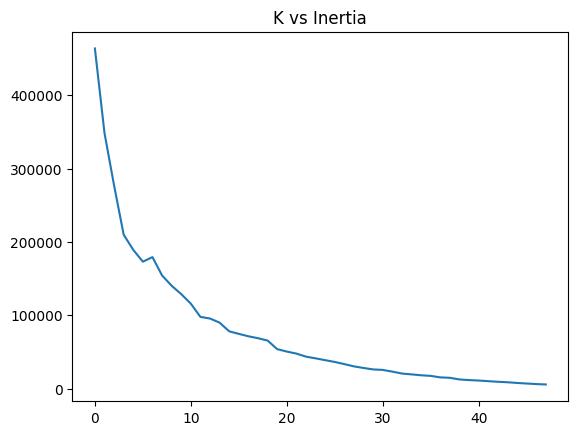

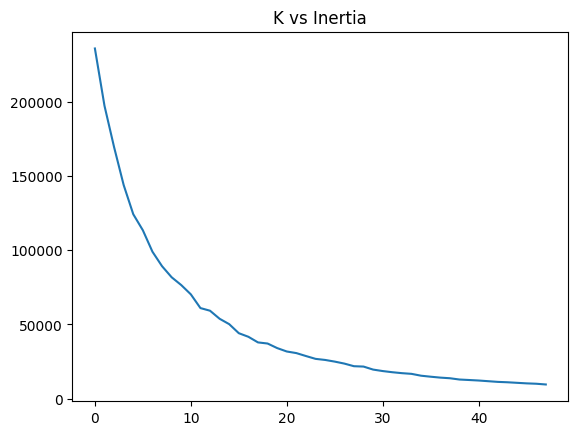

In [131]:
get_elbow_graph(processed_walmart_cust.iloc[:, 1:])
get_elbow_graph(processed_walmart_transaction.iloc[:, 1:])

In [43]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def map_cust_categories(df1):
    """
    Mapped the numeric categories for walmart_cust
    """
    scaler = StandardScaler()
    cat_transact = df1.groupby('ProductCategory').mean()
    cat_transact['Revenue'] = scaler.fit_transform(cat_transact[['Revenue']])
    
    cat_cust = walmart_cust.groupby('ProductCategory').mean()
    cat_cust['Revenue'] = scaler.fit_transform(cat_cust[['Revenue']])
    

    #Testing centroid matching based on average money spent per categories
    distance_matrix = cdist(cat_cust, cat_transact, metric='euclidean') #Pairwise distance
    closest_indices = np.argmin(distance_matrix, axis = 1)
    
    #Showing distance
    closest_distances = distance_matrix[np.arange(len(cat_cust)), closest_indices]
    map_dict = defaultdict()
    total_dist = 0
    for i, j in enumerate(closest_indices):
        name = list(cat_transact.index)[j]
        map_dict[i+1] = name
        total_dist += closest_distances[i]

    print('total distance is', total_dist)

    return map_dict

mapping = map_cust_categories(walmart_transactions)
mapping


total distance is 3.660570459082608


defaultdict(None,
            {1: 'Produce',
             2: 'Beverages',
             3: 'Meat & Seafood',
             4: 'Bakery',
             5: 'Dairy & Eggs',
             6: 'Snacks',
             7: 'Snacks',
             8: 'Non-Food Items',
             9: 'Snacks',
             10: 'Prepared Foods',
             11: 'Dairy & Eggs',
             12: 'Bakery',
             13: 'Bakery',
             14: 'Produce',
             15: 'Produce',
             16: 'Produce',
             17: 'Meat & Seafood',
             18: 'Bakery',
             19: 'Bakery',
             20: 'Bakery'})

### Creating important datasets for predictive modelling

In [44]:
tran_cols = ['SalesId', 'UnitPrice', 'Quantity', 'ProductCategory', 'ProductName', 'Revenue']
df_transaction_analysis = df_transaction_merged[tran_cols]
df_transaction_analysis.to_csv('../../Data_source/Walmart_transactions.csv')
df_transaction_analysis.head()


,SalesId,UnitPrice,Quantity,ProductCategory,ProductName,Revenue
0,82319,0.0525,93,Beverages,Wine - Wyndham Estate Bin 777,4.8825
1,15022,5.1100,28,Meat & Seafood,"Pork - Back, Long Cut, Boneless",143.0800
2,11624,7.3675,33,Beverages,Tea - Herbal Sweet Dreams,243.1275
3,63101,2.0825,76,Beverages,Wine - Carmenere Casillero Del,158.2700
4,29702,0.6475,8,Pantry,Oil - Margarine,5.1800


In [48]:
#Took the category mapping with df_transactions since it has the lower total distance compared to df_commerce
df_cust_analysis = df_cust.copy()
df_cust_analysis['Product_Category'] = df_cust_analysis['Product_Category'].map(mapping)
df_cust_analysis.to_csv('../../Data_source/Walmart_cust.csv')
df_cust_analysis.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,Meat & Seafood,97.702240
1,1000001,P00248942,F,0-17,10,A,2,0,Produce,177.428202
2,1000001,P00087842,F,0-17,10,A,2,0,Bakery,16.598875
3,1000001,P00085442,F,0-17,10,A,2,0,Bakery,12.338264
4,1000002,P00285442,M,55+,16,C,4+,0,Non-Food Items,93.021404


In [134]:
#Only have 6 categories
comm_cols = ['invoice_id', 'customer_type', 'gender', 'product_line', 'unit_price', 'quantity', 'total', 'payment_method', 'rating', 'dtme', 'tme', 'time_of_day', 'day_name', 'month_name']
df_commerce_analysis = df_commerce[comm_cols]
df_commerce_analysis.to_csv('../../Data_source/Walmart_commerce.csv')
df_commerce_analysis.head()

,invoice_id,customer_type,gender,product_line,unit_price,quantity,total,payment_method,rating,dtme,tme,time_of_day,day_name,month_name
0,750-67-8428,Member,Female,Health and beauty,74.69,7,548.9715,Ewallet,9.1,2019-01-05 00:00:00,13:08:00,afternoon,Saturday,January
1,226-31-3081,Normal,Female,Electronic accessories,15.28,5,80.2200,Cash,9.6,2019-03-08 00:00:00,10:29:00,morning,Friday,March
2,631-41-3108,Normal,Male,Home and lifestyle,46.33,7,340.5255,Credit card,7.4,2019-03-03 00:00:00,13:23:00,afternoon,Sunday,March
3,123-19-1176,Member,Male,Health and beauty,58.22,8,489.0480,Ewallet,8.4,2019-01-27 00:00:00,20:33:00,evening,Sunday,January
4,373-73-7910,Normal,Male,Sports and travel,86.31,7,634.3785,Ewallet,5.3,2019-02-08 00:00:00,10:37:00,morning,Friday,February


In [34]:
#Filtering and cleaning the product df
cols = ['sku', 'categories', 'category_name', 'discount', 'initial_price', 'final_price', 'rating_stars', 'review_count', 'timestamp']
df_products_analysis = df_products[cols]
df_products_analysis.fillna(0, inplace=True)
df_products_analysis['timestamp'] = pd.to_datetime(df_products_analysis['timestamp'])
df_products_analysis['categories'] = df_products_analysis['categories'].apply(lambda x: eval(x)[0]) 
df_products_analysis['discount'] = df_products_analysis['discount'].apply(lambda x: float(str(x)[1:] if x else 0))

def avg_rating(dict_str):
    rating_dict = eval(dict_str)
    if len(rating_dict) == 0:
        return 0
    else:
        count = sum(rating_dict.values())
        total = 0   
        for k, v in rating_dict.items():
            if k == 'five_stars':
                total += v * 5
            elif k == 'four_stars':
                total += v * 4
            elif k == 'three_stars':
                total += v * 3
            elif k == 'two_stars':
                total += v * 2
            elif k == 'one_star':
                total += v * 1
        return total / count

df_products_analysis['avg_rating'] = df_products_analysis['rating_stars'].apply(avg_rating)
df_products_analysis.drop(columns=['rating_stars'], axis = 1, inplace=True)
df_products_analysis.to_csv('../../Data_source/Walmart_products.csv')
df_products_analysis.head()

,sku,categories,category_name,discount,initial_price,final_price,review_count,timestamp,avg_rating
0,173530386,Beauty,Eye Shadow Stick,0.00,0.00,22.90,6,2024-08-24,4.000000
1,430528189,Home,Blackout Curtains,22.92,70.80,47.88,58,2024-08-24,4.551724
2,6013308220,Clothing,Plus Size Tops,4.75,37.99,33.24,2,2024-08-24,5.000000
3,161657830,Home,King Duvet Covers,22.00,71.99,49.99,101,2024-08-24,4.663366
4,5397071399,Clothing,Boys Outfit Sets,16.01,29.00,12.99,15,2024-08-25,4.400000


### Helper functions

In [138]:
def get_sub_df(df, col_name):
    clusters_characteristics = df.loc[:, df.columns.str.contains(col_name)]
    return clusters_characteristics

def stacked_bar_chart(df, col_name):
    clusters_characteristics = get_sub_df(df, col_name)
    clusters_characteristics.reset_index(inplace=True)
    ax = clusters_characteristics.set_index('labels').plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(f"Stacked Bar Chart of {col_name} per Cluster")
    plt.xlabel("Cluster Labels")
    plt.ylabel("Number of Customers")
    
    # Move legend outside
    ax.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    plt.show()


### Summarize and model real data distributions (with df_cust )

Getting customer attributes distributions
- Engineer customer-level features


In [135]:
cat = df_cust_analysis.iloc[:,2:-1]
purchase = df_cust_analysis.iloc[:,-1]
encoded_X = process_categorical_df(cat,30)

categorical columns are: ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category']
text columns are: []


In [136]:
User_level_df = pd.concat([df_cust_analysis['User_ID'], encoded_X, purchase], axis = 1)
User_level_df.head()

,User_ID,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_1,Occupation_2,...,Stay_In_Current_City_Years_4+,Marital_Status_1,Product_Category_Beverages,Product_Category_Dairy & Eggs,Product_Category_Meat & Seafood,Product_Category_Non-Food Items,Product_Category_Prepared Foods,Product_Category_Produce,Product_Category_Snacks,Purchase
0,1000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,97.702240
1,1000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,177.428202
2,1000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.598875
3,1000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.338264
4,1000002,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,93.021404


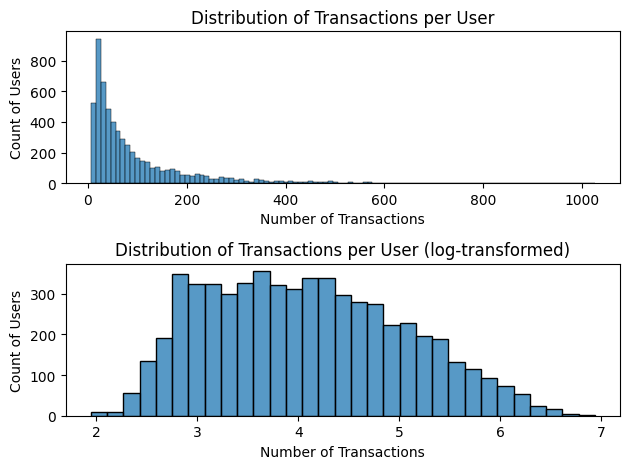

In [220]:
User_level = User_level_df.groupby('User_ID').sum()

Transaction_per_user = df_cust_analysis.groupby('User_ID').size() 
plt.subplot(2,1,1)
sns.histplot(Transaction_per_user)
plt.title('Distribution of Transactions per User')
plt.xlabel('Number of Transactions')
plt.ylabel('Count of Users')

plt.subplot(2,1,2)
sns.histplot(np.log1p(Transaction_per_user))
plt.title('Distribution of Transactions per User (log-transformed)')
plt.xlabel('Number of Transactions')
plt.ylabel('Count of Users')
plt.tight_layout()
plt.show()





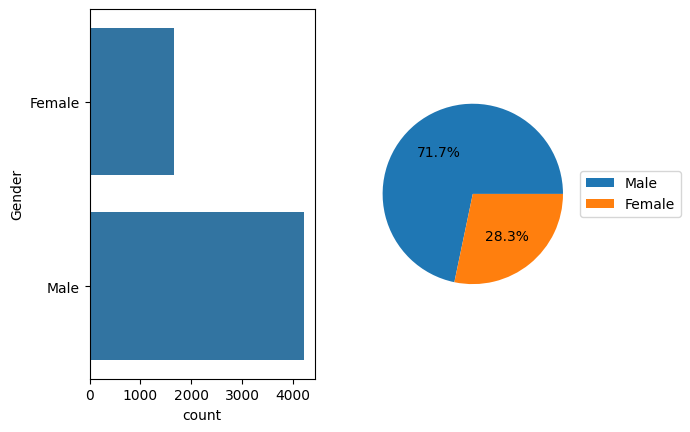

In [ ]:
Gender_dist = get_sub_df(User_level, 'Gender')

Gender_dist['Gender'] = Gender_dist['Gender_M'].apply(lambda x: 'Male' if x > 0 else 'Female') 
plt.subplot(1,2,1)
sns.countplot(Gender_dist['Gender'])
plt.subplot(1,2,2)
plt.pie(Gender_dist['Gender'].value_counts()/len(Gender_dist), autopct='%1.1f%%')
plt.legend(Gender_dist['Gender'].value_counts().index, loc='center', bbox_to_anchor=(1.2, 0.5))
plt.show()


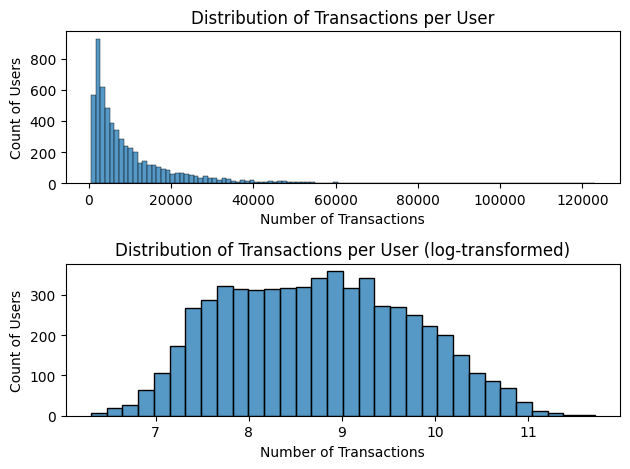

In [221]:
Purchase_dist = User_level.iloc[:,-1] #Log-nomral or gamma distribution so log turns it into normal dist
plt.subplot(2,1,1)
sns.histplot(Purchase_dist)
plt.title('Distribution of Transactions per User')
plt.xlabel('Number of Transactions')
plt.ylabel('Count of Users')

plt.subplot(2,1,2)
sns.histplot(np.log1p(Purchase_dist))
plt.title('Distribution of Transactions per User (log-transformed)')
plt.xlabel('Number of Transactions')
plt.ylabel('Count of Users')
plt.tight_layout()
plt.show()

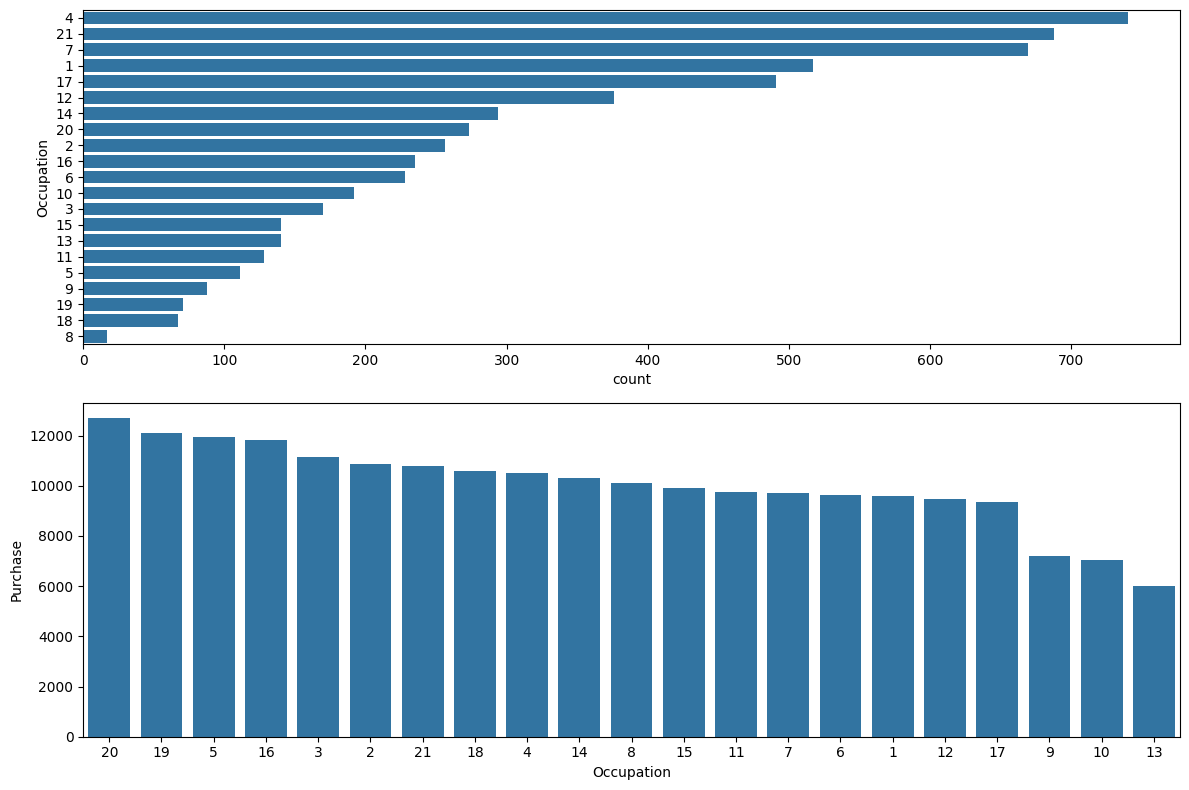

In [265]:
# Create occupation name column by finding non-zero occupation column per row
Occupation_dist = get_sub_df(User_level, 'Occupation')
Occupation_per_user = Occupation_dist.apply(lambda row: row[row > 0].index[0].split('_')[1] if any(row > 0) else '21', axis=1)

plt.figure(figsize=(12, 8))

# Sort occupation values by count for better visualization
occupation_counts = Occupation_per_user.value_counts()
plt.subplot(2,1,1)
sns.countplot(data=Occupation_per_user, order=occupation_counts.index)
plt.xlabel('count')
plt.ylabel('Occupation')

occ_purchase = pd.concat([Occupation_per_user, Purchase_dist], axis = 1)
occ_purchase.columns = ['Occupation', 'Purchase']
purchase_occ = occ_purchase.groupby('Occupation').mean().sort_values(by='Purchase', ascending=False)
plt.subplot(2,1,2)
sns.barplot(x=purchase_occ.index, y='Purchase', data=purchase_occ)
plt.xlabel('Occupation')
plt.ylabel('Purchase')
plt.tight_layout()
plt.show()


<Axes: xlabel='count'>

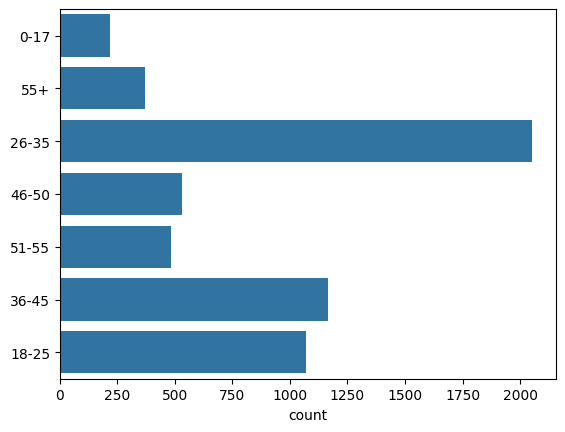

In [222]:
Age_dist = get_sub_df(User_level, 'Age')
Age_per_user= Age_dist.apply(lambda row: row[row > 0].index[0].split('_')[1] if any(row > 0) else '0-17', axis=1)
sns.countplot(Age_per_user)


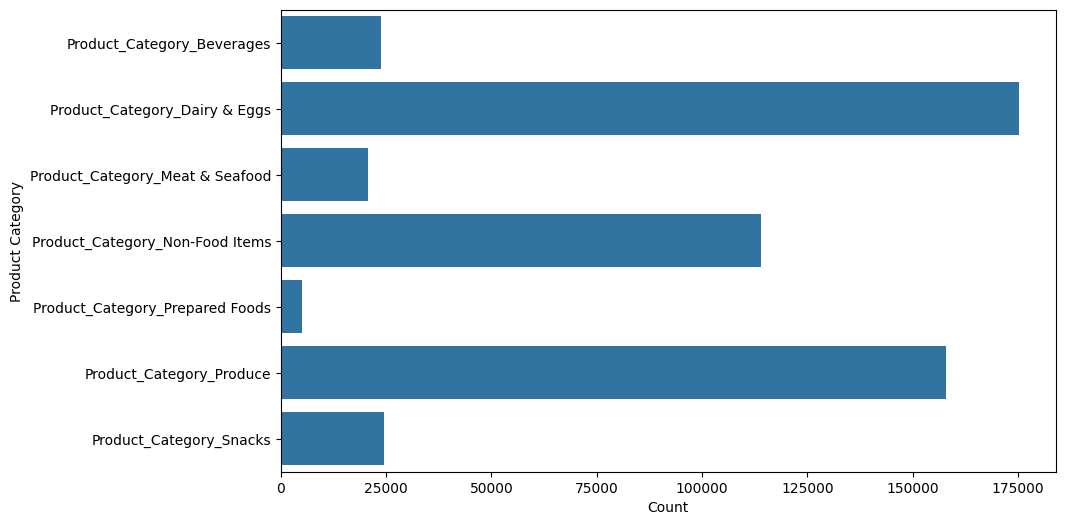

In [231]:
Product_dist = get_sub_df(User_level, 'Product_Category')
plt.figure(figsize=(10,6))
sns.barplot(y=Product_dist.sum().index, x=Product_dist.sum().values)
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.show()


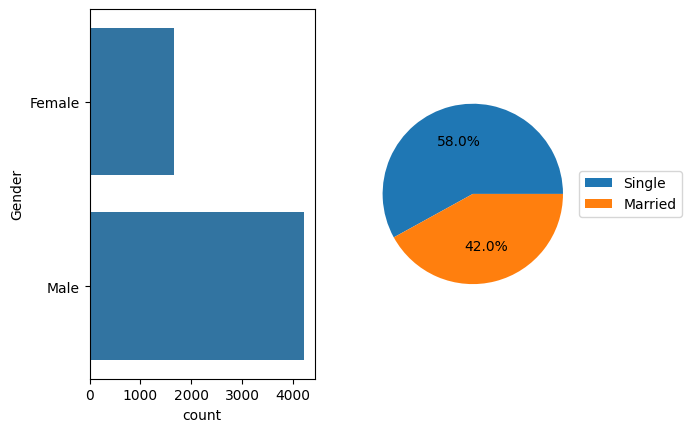

In [240]:
Marital_dist = get_sub_df(User_level, 'Marital_Status')
Marital_dist['Marital_Status'] = Marital_dist['Marital_Status_1'].apply(lambda x: 'Married' if x > 0 else 'Single')
plt.subplot(1,2,1)
sns.countplot(Gender_dist['Gender'])
plt.subplot(1,2,2)
plt.pie(Marital_dist['Marital_Status'].value_counts()/len(Marital_dist), autopct='%1.1f%%')
plt.legend(Marital_dist['Marital_Status'].value_counts().index, loc='center', bbox_to_anchor=(1.2, 0.5))
plt.show()


##### Walmart kmeans clustering

categorical columns are: ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category']
text columns are: []


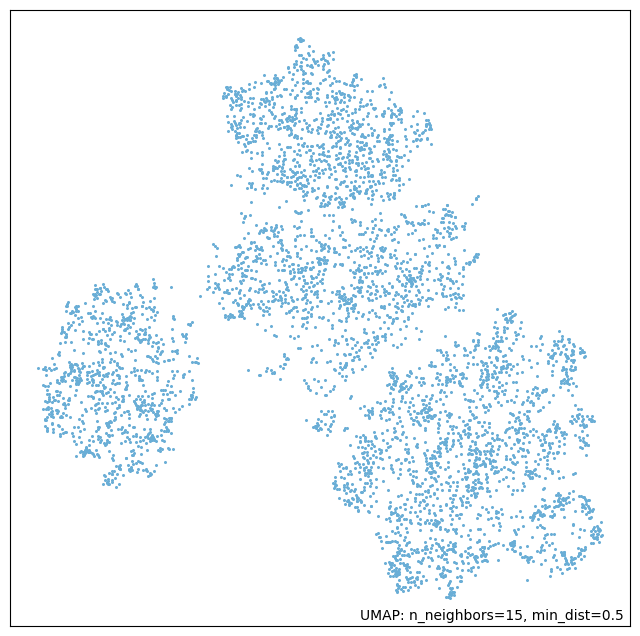

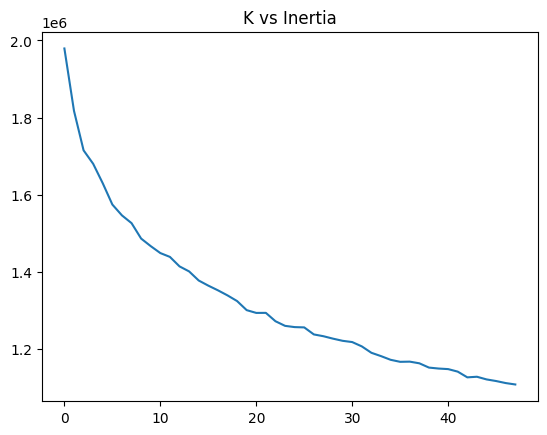

In [127]:
#Running UMAP to find best clustering
mapper = sampled_umap_plot(encoded_X, Sample_size=5000)

#Clear separation so k-means would be great
get_elbow_graph(encoded_X)

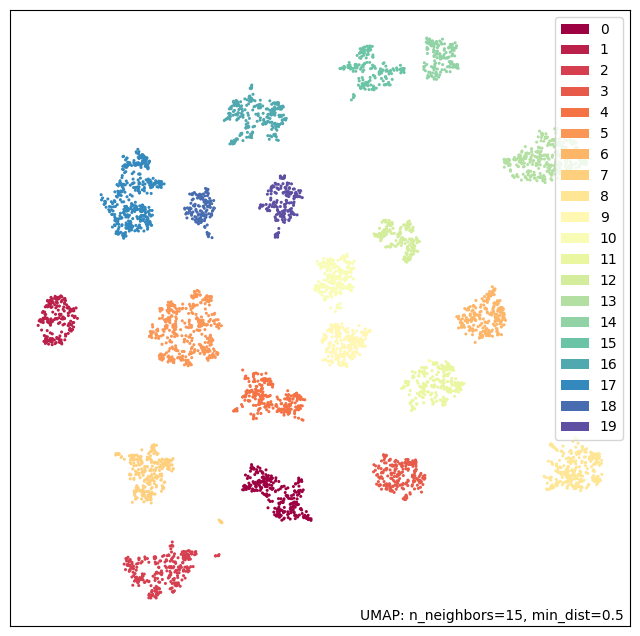

In [95]:
#Running Kmeans
model = KMeans(n_clusters = 20, random_state=2020)
model.fit(encoded_X)
labels = model.labels_

walmart_cust_clusters = pd.concat([encoded_X, pd.DataFrame(labels, columns=['labels'])], axis = 1)
final_cust_mapper = sampled_umap_plot(walmart_cust_clusters, 'labels',5000)

In [96]:
cust_top10features = get_feature_importance(X=encoded_X, y=purchase).head(10)
cust_top10features #The product categories influences the most 

,feature,importance
39,Product_Category_Produce,0.273705
40,Product_Category_Snacks,0.225818
38,Product_Category_Prepared Foods,0.215625
34,Product_Category_Beverages,0.089400
37,Product_Category_Non-Food Items,0.067231
36,Product_Category_Meat & Seafood,0.063123
35,Product_Category_Dairy & Eggs,0.034138
28,City_Category_C,0.002284
26,Occupation_20,0.001366
13,Occupation_7,0.001355


##### Walmart customer cluster analysis

In [97]:
cust_clusters_groups = walmart_cust_clusters.groupby('labels').sum()
cust_clusters_groups.head()

,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_1,Occupation_2,Occupation_3,...,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status_1,Product_Category_Beverages,Product_Category_Dairy & Eggs,Product_Category_Meat & Seafood,Product_Category_Non-Food Items,Product_Category_Prepared Foods,Product_Category_Produce,Product_Category_Snacks
labels,,,,,,,,,,,,,,,,,,,,,
0,20664.0,230.0,0.0,0.0,15027.0,12781.0,1672.0,4532.0,1668.0,896.0,...,0.0,2905.0,23273.0,1973.0,11072.0,1282.0,11032.0,486.0,0.0,1894.0
1,17565.0,22017.0,0.0,0.0,0.0,0.0,0.0,395.0,998.0,198.0,...,0.0,0.0,4987.0,1610.0,0.0,1585.0,5970.0,232.0,9904.0,1439.0
2,21253.0,0.0,27819.0,0.0,0.0,0.0,0.0,2541.0,2795.0,1559.0,...,27819.0,0.0,8583.0,1657.0,12981.0,1470.0,2705.0,327.0,5143.0,1787.0
3,14987.0,0.0,0.0,20935.0,0.0,0.0,0.0,2255.0,1260.0,1017.0,...,2405.0,3210.0,8602.0,0.0,0.0,0.0,20935.0,0.0,0.0,0.0
4,21054.0,179.0,0.0,0.0,15313.0,12142.0,0.0,4274.0,917.0,1170.0,...,3181.0,6014.0,19916.0,1826.0,0.0,1298.0,8502.0,513.0,11960.0,1716.0


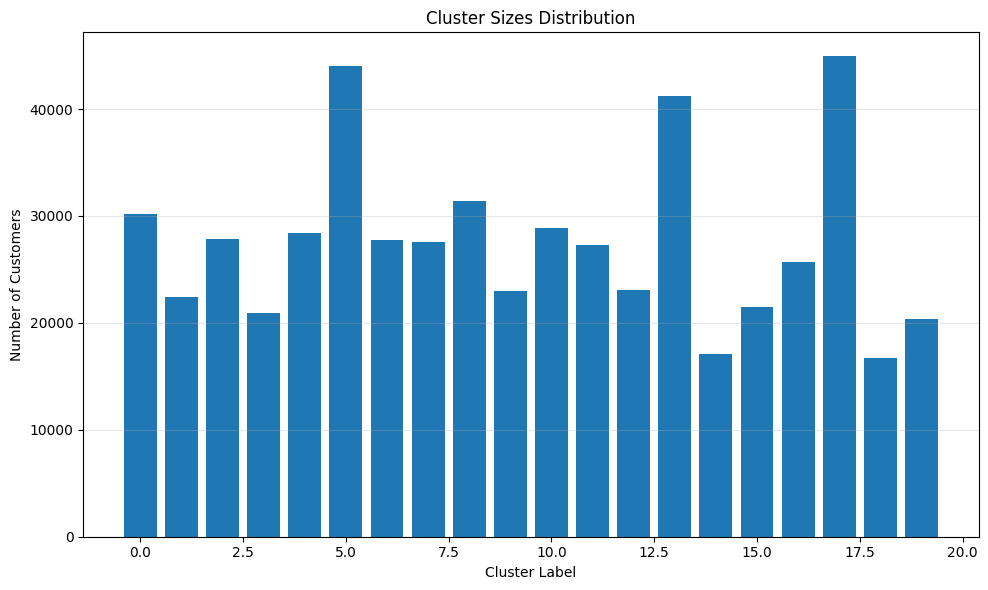

In [98]:
# Cluster sizes
cluster_sizes = walmart_cust_clusters['labels'].value_counts().sort_index()

# Plot cluster sizes with better formatting
plt.figure(figsize=(10,6))
bars = plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.title('Cluster Sizes Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()


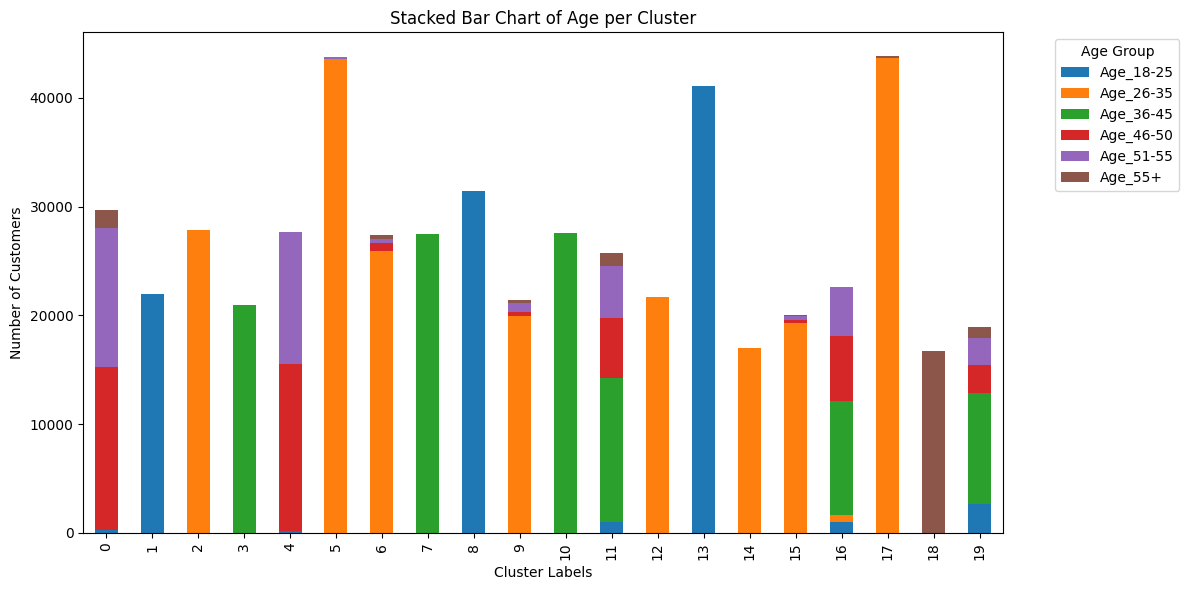

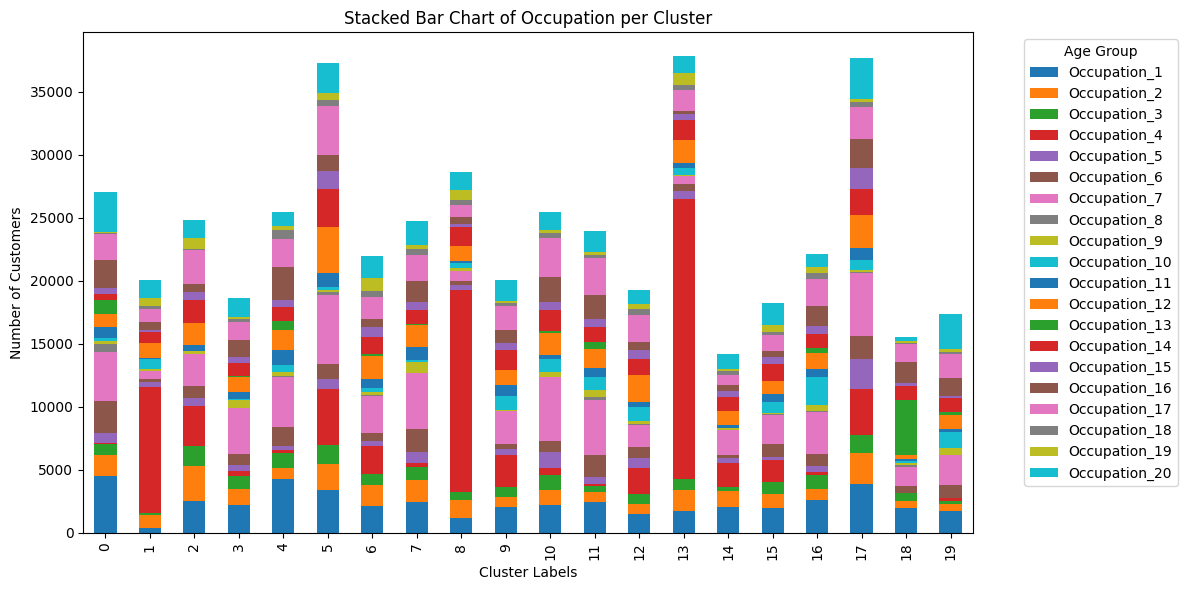

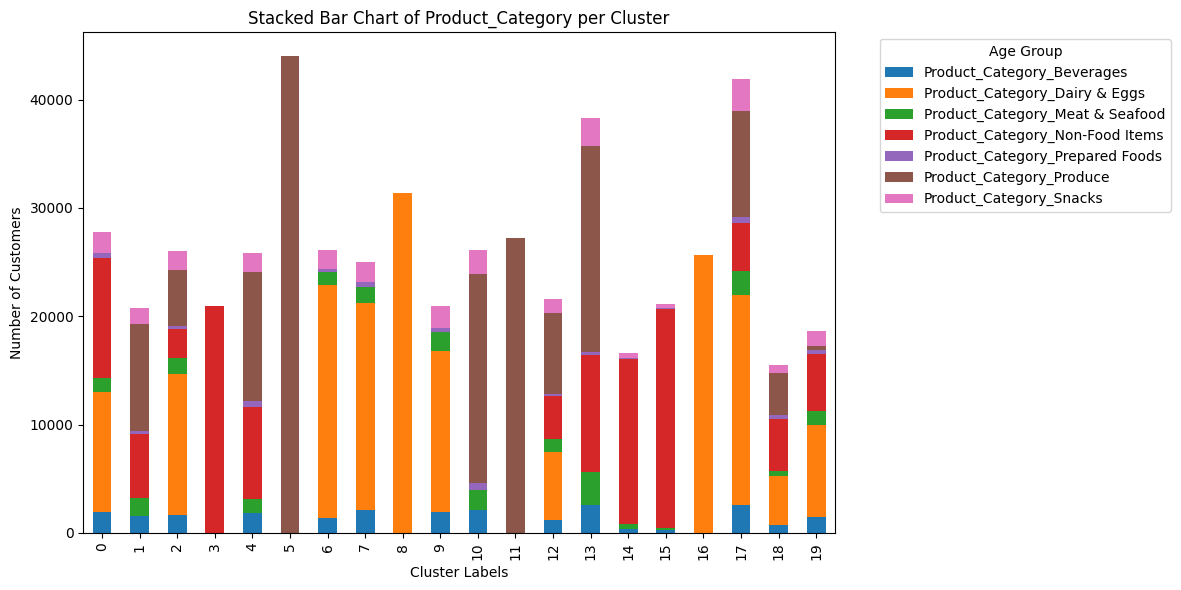

In [ ]:


#Age
# age_clusters = cust_clusters_groups.loc[:, cust_clusters_groups.columns.str.contains('Age')]
# occ_clusters = cust_clusters_groups.loc[:, cust_clusters_groups.columns.str.contains('Occupation')]
# prod_clusters = cust_clusters_groups.loc[:, cust_clusters_groups.columns.str.contains('Product_Category')]

stacked_bar_chart(cust_clusters_groups, 'Age')
stacked_bar_chart(cust_clusters_groups, 'Occupation')
stacked_bar_chart(cust_clusters_groups, 'Product_Category')





Summarize product categories and pricing
- Analyze each categories prices, product and purchase frequency

In [107]:
df_products_analysis.head()

,sku,categories,category_name,discount,initial_price,final_price,review_count,timestamp,avg_rating
0,173530386,Beauty,Eye Shadow Stick,0.00,0.00,22.90,6,2024-08-24,4.000000
1,430528189,Home,Blackout Curtains,22.92,70.80,47.88,58,2024-08-24,4.551724
2,6013308220,Clothing,Plus Size Tops,4.75,37.99,33.24,2,2024-08-24,5.000000
3,161657830,Home,King Duvet Covers,22.00,71.99,49.99,101,2024-08-24,4.663366
4,5397071399,Clothing,Boys Outfit Sets,16.01,29.00,12.99,15,2024-08-25,4.400000


In [267]:
df_products_analysis['categories'].unique()

array(['Beauty', 'Home', 'Clothing', 'Sports & Outdoors', 'Food',
       'Jewelry', 'Personal Care', 'Patio & Garden',
       'Health and Medicine', 'Pets', 'Premium Beauty', 'Baby',
       'Household Essentials', 'Home Improvement', 'Shop with Purpose',
       'Party & Occasions', 'Electronics', 'Collectibles',
       'Arts Crafts & Sewing', 'Subscriptions', 'Toys', 'Seasonal',
       'Auto & Tires'], dtype=object)

Transaction spending behavior
- Distribution of basket sizes, average total spend and frequency of purchases for each customer

In [108]:
df_commerce_analysis.head()

,invoice_id,customer_type,gender,product_line,unit_price,quantity,total,payment_method,rating,dtme,tme,time_of_day,day_name,month_name
0,750-67-8428,Member,Female,Health and beauty,74.69,7,548.9715,Ewallet,9.1,2019-01-05 00:00:00,13:08:00,afternoon,Saturday,January
1,226-31-3081,Normal,Female,Electronic accessories,15.28,5,80.2200,Cash,9.6,2019-03-08 00:00:00,10:29:00,morning,Friday,March
2,631-41-3108,Normal,Male,Home and lifestyle,46.33,7,340.5255,Credit card,7.4,2019-03-03 00:00:00,13:23:00,afternoon,Sunday,March
3,123-19-1176,Member,Male,Health and beauty,58.22,8,489.0480,Ewallet,8.4,2019-01-27 00:00:00,20:33:00,evening,Sunday,January
4,373-73-7910,Normal,Male,Sports and travel,86.31,7,634.3785,Ewallet,5.3,2019-02-08 00:00:00,10:37:00,morning,Friday,February


In [268]:
df_commerce_analysis['product_line'].unique()

array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories'], dtype=object)

In [109]:
processed_commerce_cat = process_categorical_df(df_commerce_analysis,20)
processed_commerce_cat.head()

categorical columns are: ['customer_type', 'gender', 'product_line', 'quantity', 'payment_method', 'time_of_day', 'day_name', 'month_name']
text columns are: ['invoice_id', 'unit_price', 'total', 'rating', 'dtme', 'tme']


,invoice_id,unit_price,total,rating,dtme,tme,customer_type_Normal,gender_Male,product_line_Fashion accessories,product_line_Food and beverages,...,time_of_day_evening,time_of_day_morning,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,month_name_January,month_name_March
0,750-67-8428,74.69,548.9715,9.1,2019-01-05 00:00:00,13:08:00,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,226-31-3081,15.28,80.2200,9.6,2019-03-08 00:00:00,10:29:00,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,631-41-3108,46.33,340.5255,7.4,2019-03-03 00:00:00,13:23:00,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,123-19-1176,58.22,489.0480,8.4,2019-01-27 00:00:00,20:33:00,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
4,373-73-7910,86.31,634.3785,5.3,2019-02-08 00:00:00,10:37:00,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


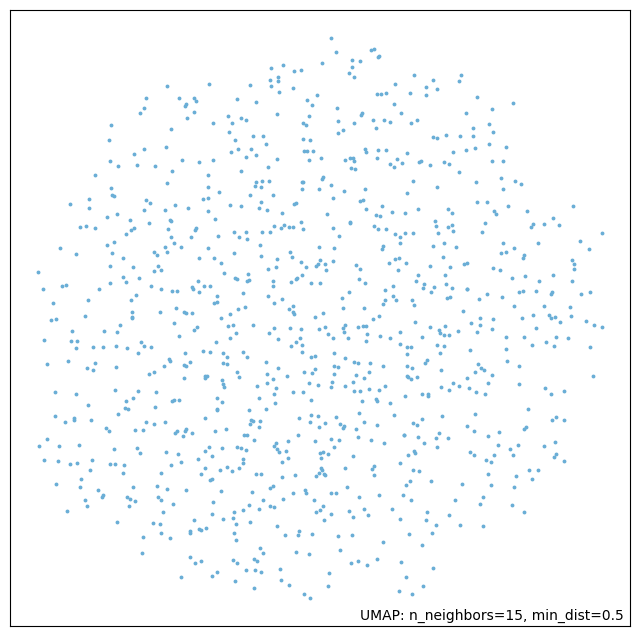

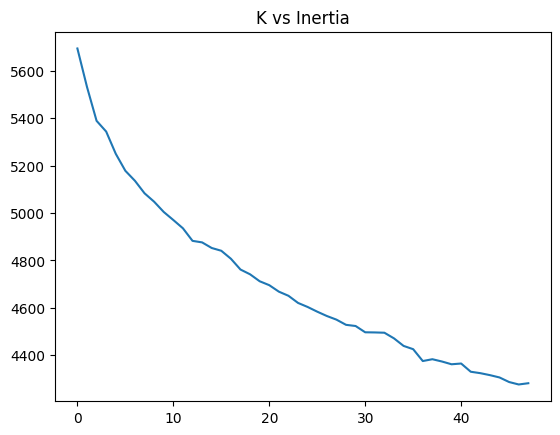

In [114]:
umap_commerce = processed_commerce_cat.drop(columns=['invoice_id', 'total', 'dtme','tme'], axis = 1)
get_umap_elbow(umap_commerce)

UMAP(min_dist=0.5, n_epochs=100, n_jobs=1, n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

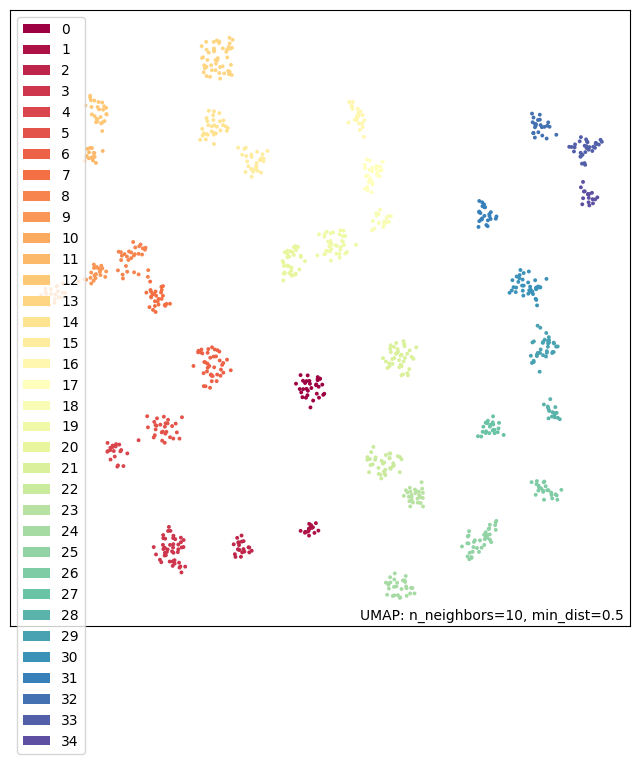

In [124]:
y_cols = ['invoice_id', 'dtme','tme', 'total', 'rating', 'unit_price']
commerce_clusters = fit_kmeans_clusters(processed_commerce_cat.drop(columns=y_cols, axis = 1), k = 35)
sampled_umap_plot(commerce_clusters, 'labels', Umap_n = 10)

### Meta clustering
Doesn't work because:
- Different number of categories from two datasets so hard to determine the right number of clusters
- Clusters from one dataset got grouped together, preventing matching with categories from another set.

Lessons:
- Know why you are doing this analysis
- Experiment faster, messy code is fine to validate approach (2 weeks is not ok)
- Decide on the requirements or when to move on (prioritize finishing tasks)


In [188]:
processed_walmart_transaction =  fit_kmeans_clusters(processed_walmart_transaction, 'Revenue', k = 9)
processed_walmart_cust = fit_kmeans_clusters(processed_walmart_cust, 'Revenue', k = 9)

walmart_transactions_groups = processed_walmart_transaction.groupby('labels').mean()[['Scaled_Revenue']]
walmart_cust_groups = processed_walmart_cust.groupby('labels').mean()[['Scaled_Revenue']]

In [202]:
#
walmart_transactions_groups['group'] = 1
walmart_cust_groups['group'] = 2

merged = pd.concat([walmart_transactions_groups, walmart_cust_groups], axis = 0)

#Meta clustering
merged = pd.concat([walmart_transactions_groups, walmart_cust_groups], axis = 0)
model = KMeans(n_clusters=9, random_state=2020)
model.fit(merged.iloc[:, 0:1])
merged['meta_clusters'] = model.labels_
print(merged['meta_clusters'].unique())
merged.reset_index(inplace=True)

#Getting cluster mapping from meta clusters
#1 for transactions, 2 for customers
clusters_mappings = defaultdict()
merged['labels_group'] = merged['labels'].astype(str) + '-' + merged['group'].astype(str)
zipped = list(zip(merged['meta_clusters'], merged['labels_group']))
for i, v in zipped:
    clusters_mappings[v] = i

#Mapping the labels with cluster labels
processed_walmart_cust['meta_clusters'] = processed_walmart_cust['labels'].astype(str) + '-' + '2'
processed_walmart_cust['meta_clusters'] = processed_walmart_cust['meta_clusters'].map(clusters_mappings)
processed_walmart_transaction['meta_clusters'] = processed_walmart_transaction['labels'].astype(str) + '-' + '1'
processed_walmart_transaction['meta_clusters'] = processed_walmart_transaction['meta_clusters'].map(clusters_mappings)
print(processed_walmart_transaction['meta_clusters'].unique())
print(processed_walmart_cust['meta_clusters'].unique())


[5 7 3 4 1 8 6 2 0]
[5 1 4 7 3]
[2 4 6 8 1 0 5]


In [209]:
#Getting category counts
cat_dist_cust = processed_walmart_cust.groupby('meta_clusters').sum().iloc[:, 1:-1]
cat_dist_transactions = processed_walmart_transaction.groupby('meta_clusters').sum().iloc[:, 1:-1]

# Merge based on labels instead of meta_clusters
cat_dist_transactions = cat_dist_transactions.reset_index()
cat_dist_cust = cat_dist_cust.reset_index()

# Merge the two datasets on meta_clusters with outer join to show all clusters
merged_distributions = pd.merge(cat_dist_cust, cat_dist_transactions, on='meta_clusters', how='outer')
merged_distributions = merged_distributions.fillna(0)  # Fill NaN values with 0
merged_distributions.head(5)

,meta_clusters,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8,ProductCategory_9,ProductCategory_10,...,ProductCategory_Beverages,ProductCategory_Dairy & Eggs,ProductCategory_Meat & Seafood,ProductCategory_Non-Food Items,ProductCategory_Pantry,ProductCategory_Prepared Foods,ProductCategory_Produce,ProductCategory_Snacks,ProductCategory_Uncategorized,Scaled_Revenue_y
0,0,0.0,0.0,0.0,66246.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,4437.0,0.0,0.0,0.0,6363.0,1728.0,0.0,194.0,4057.0,...,1319.0,214.0,1138.0,297.0,884.0,562.0,1298.0,665.0,47.0,13741.819340
2,2,0.0,14009.0,0.0,0.0,1377.0,220.0,0.0,69.0,230.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1267.0,188.0,923.0,257.0,619.0,384.0,895.0,888.0,23.0,21405.241796
4,4,0.0,5272.0,0.0,0.0,12210.0,1649.0,0.0,116.0,790.0,...,5789.0,2072.0,5099.0,925.0,3290.0,2074.0,4053.0,2477.0,451.0,27555.779717


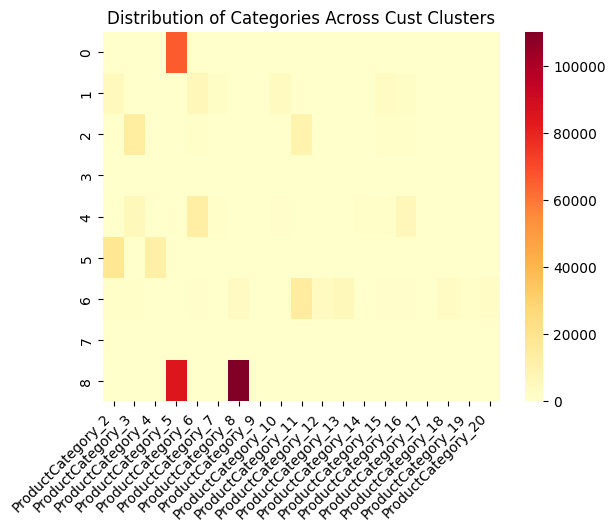

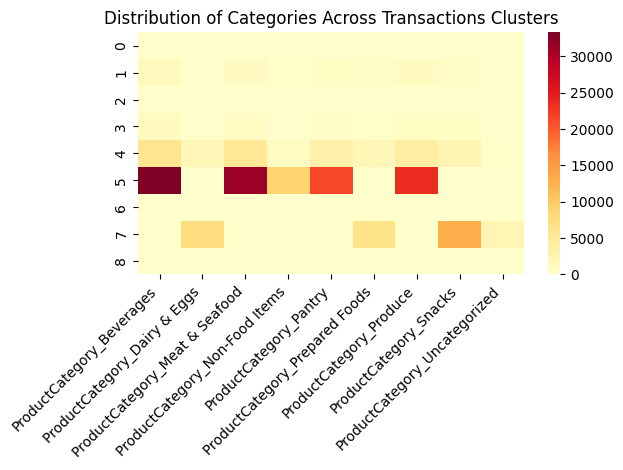

In [210]:
# Remove scaled revenue columns and plot heatmap
plt.figure()
sns.heatmap(merged_distributions.iloc[:,1:-11], fmt='.0f', cmap='YlOrRd')
plt.title('Distribution of Categories Across Cust Clusters')
plt.xticks(rotation=45, ha='right')

plt.figure()
sns.heatmap(merged_distributions.iloc[:,-10:-1], fmt='.0f', cmap='YlOrRd')
plt.title('Distribution of Categories Across Transactions Clusters')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

In [112]:
# Get column names with non-zero values for each cluster from second heatmap
non_zero_cols = {}
for cluster in merged_distributions['meta_clusters'].unique():
    mask = merged_distributions.iloc[:,-10:-1].loc[merged_distributions['meta_clusters']==cluster].iloc[0]
    top2cols = mask.sort_values(ascending=False).head(2).index
    non_zero_cols[f"Cluster 1-{cluster}"] = list(top2cols)
    
    cluster_data = merged_distributions.iloc[:,1:-11].loc[merged_distributions['meta_clusters']==cluster].iloc[0]
    # Sort by value and get top 3 column names
    top_3_cols = cluster_data.sort_values(ascending=False).head(2).index
    non_zero_cols[f"Cluster 2-{cluster}"] = list(top_3_cols)
    
print("\nCategories present in each cluster:")
for cluster, categories in non_zero_cols.items():
    print(f"{cluster}: {", ".join([i.split('_')[1] for i in categories])}")
    




Categories present in each cluster:
Cluster 1-0: Meat & Seafood, Non-Food Items
Cluster 2-0: 4, 12
Cluster 1-1: Beverages, Prepared Foods
Cluster 2-1: 6, 10
Cluster 1-2: Pantry, Beverages
Cluster 2-2: 5, 3
Cluster 1-3: Dairy & Eggs, Prepared Foods
Cluster 2-3: 3, 16
Cluster 1-5: Prepared Foods, Beverages
Cluster 2-5: 8, 2
Cluster 1-6: Meat & Seafood, Beverages
Cluster 2-6: 2, 16
Cluster 1-9: Produce, Snacks
Cluster 2-9: 5, 11
Cluster 1-10: Beverages, Produce
Cluster 2-10: 8, 2
Cluster 1-12: Prepared Foods, Beverages
Cluster 2-12: 2, 12
Cluster 1-13: Uncategorized, Beverages
Cluster 2-13: 6, 2


### Clustering transactions 
Seems like either overlapping clusters or soft transtitions so will try (H)DBSCAN

In [8]:
model_DB = DBSCAN(eps=0.3, min_samples=5)
model_HDB = HDBSCAN(min_cluster_size=30, min_samples=10)
model_DB.fit(X_train)
model_HDB.fit(X_train)
labels = model_DB.labels_
labels_HDB = model_HDB.labels_

"""
Based on the silhouette score, DBSCAN (0.403) is better than HDBSCAN (-0.1455)
"""

'\nBased on the silhouette score, DBSCAN (0.403) is better than HDBSCAN (-0.1455)\n'

categorical columns are: ['branch', 'city', 'customer_type', 'gender', 'product_line', 'payment_method', 'time_of_day', 'day_name', 'month_name']
text columns are: ['invoice_id', 'dtme', 'tme']


/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/macos/Personal_projects/Portfolio/Project_1_Walmart/Walmart/lib/python3.12/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value fo

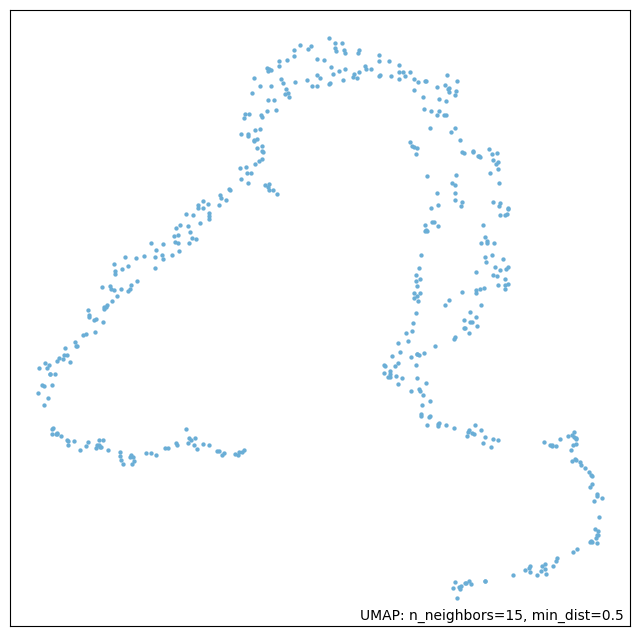

In [5]:
"""
Walmart commerce:
- cat var: branch, gender, customer_type, product_line, payment_method
- num var: rest
- time var: dtme, tme, time_of_day, day_name, month_name
"""

df_commerce_processed, text_cols = process_dataframe(df_commerce, 20)

commerce_mapper = sampled_umap_plot(df_commerce_processed, Sample_size=500)
df_commerce_umap = commerce_mapper.transform(df_commerce_processed)

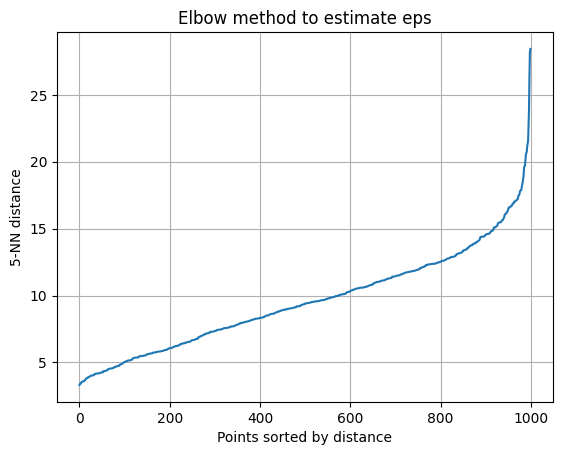

In [24]:
eps_knn_elbow(df_commerce_processed)

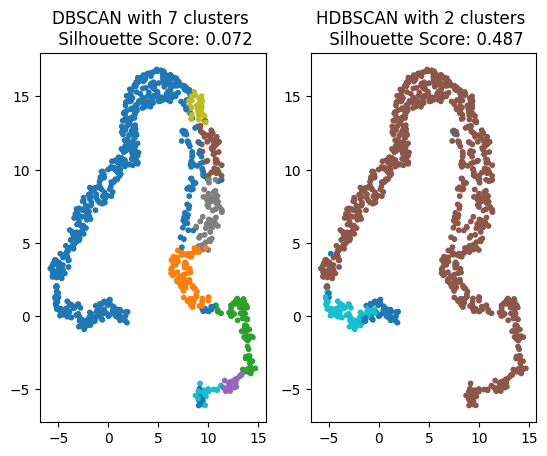

In [45]:
DB_m, DB_l, HDB_m, HDB_l = both_SCAN_fit_and_labels(df_commerce_processed, df_commerce_umap, [17, 25], 20)

### Agent-based model to simulate behavior

Cluster segments to reflect variety

Incorporate correlationn and association rules

Compare performance with Generative Models

Optional: Add events (promotional campaigns, holidays, weekly/monthly cycles)

### Validate synthetic dataset
- Compare distribution plots between real and synthetic
- Check segment proportions
- Iterate and refine accordingly